# Beyond Visible Spectrum: AI for Agriculture 2026
Task 2:  Boosting Automatic Crop Diseases Classification using Sentinel Satellite Data and Self-Supervised Learning (SSL)

Disclaimer:
- "INPUT" denotes the flag that needs to be updated.

In [ ]:
# ========================
# Settining to run the code fully or partially
# ========================
do_ssl_pretraining=False
do_downstream_task=True
do_hyperparameter_tuning=False
do_inference=True

# If want to skip SSL and downstream training and directly do inference using a saved checkpoint, set this to True
# The checkpoints used here is from the output of the downstream training in this notebook.
do_quick_inference_using_saved_ckpt=True 

In [ ]:
# ========================
# Installing necessary libraries
# ========================
!pip install torchgeo --quiet
!pip install optuna --quiet
!pip install optuna-integration[pytorch_lightning] --quiet

In [12]:
import torch
torch.cuda.empty_cache()

# ========================
# Imports
# ========================
import os
import glob
import time
import random
import argparse
from datetime import datetime
from dataclasses import dataclass
from typing import Optional, Sequence
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import Resampling as WarpResampling

from torchvision import transforms
import kornia.augmentation as K

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from torchmetrics.classification import MulticlassF1Score

from torchgeo.models import resnet50, ResNet50_Weights
from torchgeo.trainers.moco import MoCoTask

from prettytable import PrettyTable

import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [13]:
# ========================
# Reproducibility settings
# ========================
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

pl.seed_everything(seed, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)


Seed set to 42


### Dataset subset code for SSL pre-training

In [3]:
'''
SSL pretraining code for creating subset of data with only one timestamp per folder_id. This is used to create a smaller dataset for faster experimentation. 
The code selects the middle timestamp folder for each folder_id and copies its contents to a new destination folder.
This is not necessary to run.
'''

# import os
# import shutil

# # Paths
# source_root = "/home/krschap/rabina/data/s2a"
# destination_root="/home/krschap/rabina/data/s2a_subset"

# # Make destination folder if it doesn't exist
# os.makedirs(destination_root, exist_ok=True)

# # Iterate over each folder_id
# for folder_id in os.listdir(source_root):
#     folder_path = os.path.join(source_root, folder_id)
#     if not os.path.isdir(folder_path):
#         continue

#     # Get list of timestamp folders and sort
#     timestamps = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
#     if not timestamps:
#         continue

#     timestamps.sort()  # sort alphabetically or numerically
#     mid_index = len(timestamps) // 2  # middle folder
#     mid_timestamp = timestamps[mid_index]

#     # Source and destination paths
#     src_timestamp_path = os.path.join(folder_path, mid_timestamp)
#     dst_folder_id_path = os.path.join(destination_root, folder_id)
#     dst_timestamp_path = os.path.join(dst_folder_id_path, mid_timestamp)

#     # Make destination folder
#     os.makedirs(dst_timestamp_path, exist_ok=True)

#     # Copy all files from selected timestamp folder
#     for item in os.listdir(src_timestamp_path):
#         src_item = os.path.join(src_timestamp_path, item)
#         dst_item = os.path.join(dst_timestamp_path, item)
#         if os.path.isdir(src_item):
#             shutil.copytree(src_item, dst_item)
#         else:
#             shutil.copy2(src_item, dst_item)

#     print(f"Copied {mid_timestamp} from {folder_id} to new folder.")

# print("Done!")


'\nSSL pretraining code for creating subset of data with only one timestamp per folder_id. This is used to create a smaller dataset for faster experimentation. \nThe code selects the middle timestamp folder for each folder_id and copies its contents to a new destination folder.\nThis is not necessary to run.\n'

### SSL Pre-training related Utility Functions

In [5]:
# Timestamp for logging / checkpoints
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
@dataclass
class DataConfig:
    data_root_dir: str = "/home/krschap/rabina/data/s2a"
    num_workers: int = 1

@dataclass
class TrainingConfig:
    experiment_out_dir: str = "ssl_moco_"
    model: str = "resnet50"
    in_channels: int = 13
    version: int = 2
    lr: float = 1e-4
    use_peft: bool = False
    temperature: float = 0.15
    memory_bank_size: int = 2048
    target_size: int = 224
    max_epochs: int = 100
    batch_size: int =32
    ckpt_path: Optional[str] = None
    weight_decay: float = 1e-4
    moco_momentum: float = 0.995

class SSLDataset(Dataset):
    def __init__(self, scenes, bands, transforms=None, patch_size=264):
        """
        Args:
            scenes (list): List of scene folder paths.
            bands (list): List of band names (e.g., ["B1","B2"]).
            patch_size (tuple): Size of random crop (H, W).
            transforms (callable, optional): Optional transform to apply to patches.
        """
        self.scenes = scenes
        self.bands = bands
        self.patch_size = patch_size
        self.transforms = transforms
        # Precompute all timestamp paths to treat each timestamp as a sample
        self.samples = []
        for scene_path in scenes:
            timestamps = sorted([
                d for d in os.listdir(scene_path)
                if os.path.isdir(os.path.join(scene_path, d))
            ])
            for ts in timestamps:
                self.samples.append(os.path.join(scene_path, ts))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ts_path = self.samples[idx]

        band_arrays = []

        for b in self.bands:
            path = os.path.join(ts_path, f"{b}.tif")
            with rasterio.open(path) as src:
                if src.height == self.patch_size and src.width == self.patch_size:
                    arr = src.read(1).astype(np.float32)
                else:
                    arr = src.read(
                        1,
                        out_shape=(self.patch_size, self.patch_size),
                        resampling=Resampling.bilinear
                    ).astype(np.float32)

            band_arrays.append(arr)

        # Insert fake B10
        insert_idx = 10
        b10_pad = np.zeros((self.patch_size, self.patch_size), dtype=np.float32)
        band_arrays.insert(insert_idx, b10_pad)

        img = np.stack(band_arrays, axis=0)

        # img_patch = self._random_crop(img)

        patch_tensor = torch.tensor(img, dtype=torch.float32)

        if self.transforms:
            patch_tensor = self.transforms(patch_tensor)

        return {"image": patch_tensor}

def summary_trainable(model):
    table = PrettyTable()
    table.field_names = ["Module", "Type", "Trainable Params", "Total Params"]

    for name, module in model.named_children():
        total_params = sum(p.numel() for p in module.parameters())
        trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        table.add_row([name, type(module).__name__, f"{trainable_params:,}", f"{total_params:,}"])

    total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(table)
    print(f"Total trainable parameters: {total_trainable:,} ({total_trainable / 1e6:.2f} M)")
    print(f"Total parameters: {total_params:,} ({total_params / 1e6:.2f} M)")


# def main(data_root_dir, n_samples,  batch_size, patch_size, num_workers):
def run_ssl_pretraining(data_cfg, training_cfg):
    print("Data root directory:", data_cfg.data_root_dir)
    print("========================")
    print("Dataset config:", data_cfg)
    print("========================")
    print("Training config:", training_cfg)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(training_cfg.experiment_out_dir, exist_ok=True)
    logger = CSVLogger("logs", name=f"{training_cfg.experiment_out_dir}/metrics_{timestamp}")

    aug = K.AugmentationSequential(
        # K.RandomResizedCrop(size=(training_cfg.target_size, training_cfg.target_size), scale=(0.4, 1.0)),
        K.RandomHorizontalFlip(),
        K.RandomVerticalFlip(),
        K.RandomRotation(degrees=90, p=0.5),
        K.RandomGaussianBlur(kernel_size=(7,7), sigma=(0.1, 1.5), p=0.3),
        K.RandomBrightness(brightness=(0.85, 1.15), p=0.5),
        data_keys=['input'],
    )

    if not os.path.exists(data_cfg.data_root_dir):
        raise FileNotFoundError(f"Data root directory does not exist: {data_cfg.data_root_dir}")
    scenes = sorted(glob.glob(os.path.join(data_cfg.data_root_dir, "*/")))
    bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
    # ========================
    # Train MoCo model
    # ========================
    transform = transforms.Compose([
        transforms.Resize((training_cfg.target_size, training_cfg.target_size)),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 10000) / 10000.0),
    ])
        
    dataset = SSLDataset(scenes, bands, transforms=transform, patch_size=training_cfg.target_size)
    print(len(dataset))
    print(dataset[0]['image'].shape)

    data_loader = DataLoader(
        dataset,
        batch_size=training_cfg.batch_size,
        shuffle=True,
        num_workers=data_cfg.num_workers,
        worker_init_fn=seed_worker,
        generator=g
    )
    num_batches = len(data_loader)
    print("Number of batches:", num_batches)

    import time
    task = MoCoTask(
        model=training_cfg.model,      
        weights= ResNet50_Weights.SENTINEL2_ALL_MOCO,
        in_channels=training_cfg.in_channels,       
        version=training_cfg.version,             # MoCo v2
        size=training_cfg.target_size,          
        augmentation1=aug,
        augmentation2=aug,
        lr=training_cfg.lr,
        weight_decay=training_cfg.weight_decay,
        memory_bank_size=training_cfg.memory_bank_size,
        temperature=training_cfg.temperature,
        moco_momentum=training_cfg.moco_momentum
    )

    # -----------------------------
    # PEFT / Full Fine-Tuning Logic
    # -----------------------------
    if training_cfg.use_peft:
        print("Using PEFT: freezing backbone except last block, training projection head...")
        for name, param in task.backbone.named_parameters():
            if "layer4" in name:      # optionally fine-tune last residual block
                param.requires_grad = True
            else:
                param.requires_grad = False
    else:
        print("Full fine-tuning: backbone and projection head trainable...")
        for param in task.backbone.parameters():
            param.requires_grad = True

    # Momentum backbone always frozen
    for param in task.backbone_momentum.parameters():
        param.requires_grad = False

    # Projection head always trainable
    for param in task.projection_head.parameters():
        param.requires_grad = True

    # Example usage for your task
    summary_trainable(task)

    checkpoint_callback = ModelCheckpoint(
      dirpath=training_cfg.experiment_out_dir,
      filename="ssl-best-{epoch:02d}",
      monitor="train_loss",
      mode="min",
      save_top_k=1,
      save_last=True
    )

    trainer = Trainer(
        max_epochs=training_cfg.max_epochs,
        enable_progress_bar=True, 
        log_every_n_steps=num_batches,
        precision=16,
        accelerator="gpu", # if torch.cuda.is_available() else "cpu",
        #devices = [0], # training_cfg.devices,
	    deterministic=True,
        callbacks=[checkpoint_callback],
        logger=logger)
    
    print("USING DEVICE CONFIRMATION", trainer.strategy.root_device)
    start_time=time.time()
    trainer.fit(task, data_loader, ckpt_path=training_cfg.ckpt_path)
    end_time=time.time()
    # print("After fit device:", next(task.parameters()).device)
    print(f"Training time: {(end_time-start_time)/60} min")

    torch.save(task.backbone.state_dict(),f"{training_cfg.experiment_out_dir}/ssl_backbone_{timestamp}.pth")
    torch.save(task.projection_head.state_dict(), f"{training_cfg.experiment_out_dir}/projection_head_{timestamp}.pth")
    trainer.save_checkpoint(f"{training_cfg.experiment_out_dir}/ssl_ckpt_{timestamp}.ckpt")

### Downstream related unility function


In [ ]:
# Define the dataset class
class S2Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, bands, class_idx=None, labeled=True, transform=None, target_size=264):
        self.root_dir = root_dir
        self.bands = bands
        self.labeled = labeled
        self.transform = transform
        self.class_idx = class_idx if class_idx is not None else {}
        self.samples = []
        self.target_size = target_size

        # all samples
        if labeled:
            for cls_name, label in self.class_idx.items():
                cls_dir = os.path.join(root_dir, cls_name)
                if not os.path.exists(cls_dir):
                    continue
                for img_id in sorted(os.listdir(cls_dir)):
                    img_dir = os.path.join(cls_dir, img_id)
                    if os.path.isdir(img_dir):
                        self.samples.append((img_dir, label))
        else:
            for img_id in sorted(os.listdir(root_dir)):
                img_dir = os.path.join(root_dir, img_id)
                if os.path.isdir(img_dir):
                    self.samples.append((img_dir, None))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_dir, label = self.samples[idx]
        bands_data = []
        H = W = self.target_size
        for band in self.bands:
            band_path = os.path.join(img_dir, f"{band}.tif")
            if os.path.exists(band_path):
                with rasterio.open(band_path) as src:
                    arr = src.read(1, out_shape=(H, W), 
                                   resampling=Resampling.bilinear).astype(np.float32)
            else:
                arr = np.zeros((H, W), dtype=np.float32)
            bands_data.append(torch.from_numpy(arr))

        # B10 as zeros
        if "B10" not in self.bands:
            bands_data.insert(10, torch.zeros((H, W), dtype=torch.float32))

        img = torch.stack(bands_data, dim=0)
        if self.transform:
            img = self.transform(img)
        if self.labeled:
            return img, label
        else:
            img_id = os.path.basename(img_dir)  
            return img, img_id
        
# # MEAN AND STD FROM DATA
# def calculate_stats(dataset):
#     # Stack all images into a single tensor of shape (N, 13, H, W)
#     all_images = torch.stack([img for img, _ in dataset])
#     # Compute mean and std per band (across N, H, W)
#     mean = all_images.mean(dim=(0, 2, 3)) # Shape: (13,)
#     std = all_images.std(dim=(0, 2, 3)) # Shape: (13,)
#     return mean, std

# SPLIT DATA
def stratified_split(dataset, val_ratio=0.2, seed=42):
    random.seed(seed)
    class_indices = defaultdict(list)
    for i, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(i)
    train_idx, val_idx = [], []
    for label, indices in class_indices.items():
        random.shuffle(indices)
        n_val = max(1, int(len(indices) * val_ratio))
        val_idx.extend(indices[:n_val])
        train_idx.extend(indices[n_val:])
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

# Weighted sampler + loss weights 
def weighted_sampler(dataset_subset, num_classes):
    """
    Creates WeightedRandomSampler based on class frequencies in the subset.    
    Args:
        dataset_subset: Subset or Dataset with .samples attribute
        num_classes: int 
    Returns:
        WeightedRandomSampler ready for DataLoader
    """
    # Get labels from the subset
    labels = [dataset_subset.dataset.samples[i][1] for i in dataset_subset.indices]
    labels_tensor = torch.tensor(labels)   
    # Count occurrences per class
    class_counts = torch.bincount(labels_tensor, minlength=num_classes).float()
    print("Class counts in train split:", class_counts.tolist()) 
    # Inverse frequency weights
    weights = 1.0 / (class_counts + 1e-8)           # avoid division by zero
    weights = weights / weights.sum()                # normalize
    # Assign weight to each sample
    sample_weights = [weights[label].item() for label in labels]
    g = torch.Generator()
    g.manual_seed(seed)
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
        generator = g
    )
    return sampler


# Function to load MoCo encoder
def load_moco_encoder(
    checkpoint_path=None,
    architecture="resnet50",
    verbose=True
):
    if architecture != "resnet50":
        raise NotImplementedError("Only resnet50 supported")

    # torchgeo weights
    if checkpoint_path is None:
        if verbose:
            print("Loading TorchGeo Sentinel-2 MoCo weights")
        backbone = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO)

    # Custom checkpoint
    else:
        if verbose:
            print(f"Loading custom MoCo checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location="cpu")

        # Some checkpoints store inside "state_dict"
        if "state_dict" in checkpoint:
            checkpoint = checkpoint["state_dict"]

        # Clean prefixes
        cleaned = {}
        for k, v in checkpoint.items():
            new_key = k
            for prefix in ["module.","encoder_q.", "encoder.","momentum_encoder.","backbone.",]:
                if new_key.startswith(prefix):
                    new_key = new_key[len(prefix):]
                    break
            cleaned[new_key] = v

        # Auto-detect input channel (resnet architecture default is 3)
        if "conv1.weight" not in cleaned:
            raise ValueError("conv1.weight not found in checkpoint")
        in_channels = cleaned["conv1.weight"].shape[1]
        if verbose:
            print(f"Detected input channels: {in_channels}")

        # architecture to match input checkpoint
        backbone = resnet50(weights=None)
        backbone.conv1 = nn.Conv2d(
            in_channels,
            64, #out_channels
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        # load weights
        missing, unexpected = backbone.load_state_dict(cleaned, strict=False)
        if verbose:
            print(f"Missing keys: {len(missing)}")
            print(f"Unexpected keys: {len(unexpected)}")

    # remove classification head
    if hasattr(backbone, "fc"):
        backbone.fc = nn.Identity()
    elif hasattr(backbone, "head"):
        backbone.head = nn.Identity()

    return backbone


# Downstream Classifier
class MoCoClassifier(pl.LightningModule):
    def __init__(
        self,
        encoder=None,                      # optional: pre-loaded encoder
        custom_checkpoint_path=None,       # alternative: load from path
        num_classes=4,
        lr=3e-3,
        freeze_backbone=True,
        focal_gamma=2.0,
        focal_alpha=None,
        label_smoothing=0.1,
        weight_decay=1e-5,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder", "focal_alpha"])

        # Load or use encoder
        if encoder is not None:
            self.encoder = encoder
            print("Using provided encoder")
        elif custom_checkpoint_path is not None:
            self.encoder = load_moco_encoder(checkpoint_path=custom_checkpoint_path)
        else:
            self.encoder = load_moco_encoder()  # defaults to TorchGeo

        # Feature dimension
        in_features = 2048
        self.classifier = nn.Linear(in_features, num_classes)

        # Freeze backbone for linear probe
        if freeze_backbone:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # Focal loss parameters
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
        self.label_smoothing = label_smoothing

        #train 
        self.train_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        
        # Validation metrics
        self.val_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        self.val_f1_weighted = MulticlassF1Score(num_classes=num_classes, average="weighted")

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

    def focal_loss(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits,
            targets,
            reduction="none",
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.focal_gamma
        loss = focal_weight * ce_loss

        if self.focal_alpha is not None:
            alpha = self.focal_alpha.to(logits.device)
            alpha_t = alpha[targets]
            loss = alpha_t * loss

        return loss.mean()

    def _shared_step(self, batch, stage="train"):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.focal_loss(logits, labels)
    
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
    
        # Log loss and accuracy
        self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    
        # Update and log F1 scores
        if stage == "train":
            self.train_f1_macro.update(preds, labels)
            self.log("train_f1_macro", self.train_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            # self.train_f1_macro.reset()
        elif stage == "val":
            self.val_f1_macro.update(preds, labels)
            self.val_f1_weighted.update(preds, labels)
            self.log("val_f1_macro", self.val_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            self.log("val_f1_weighted", self.val_f1_weighted.compute(), on_step=False, on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_train_epoch_end(self):
        # Log train F1 scores
        self.log("train_f1_macro", self.train_f1_macro.compute(), prog_bar=True)
        self.train_f1_macro.reset()
    
    def on_validation_epoch_end(self):
        # Log validation F1 scores
        self.log("val_f1_macro", self.val_f1_macro.compute(), prog_bar=True)
        self.log("val_f1_weighted", self.val_f1_weighted.compute(), prog_bar=True)
        self.val_f1_macro.reset()
        self.val_f1_weighted.reset()

    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optimizer = AdamW(params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode="max",
            factor=0.5,
            patience=5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1_macro",
                "interval": "epoch",
                "frequency": 1
            }
        }
    

# Training function
def train_model(
    model: pl.LightningModule,
    train_loader,
    val_loader,
    max_epochs: int = 60,
    monitor_metric: str = "val_f1_macro",
    mode: str = "max",
    patience: int = 10,
    checkpoint_dir: str = "/kaggle/working/checkpoints/moco_default"
):

    checkpoint_cb = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="moco-{epoch:03d}-{val_f1_macro:.4f}",
        monitor=monitor_metric,
        mode=mode,
        save_top_k=1,
        save_last=True,
        verbose=False
    )

    early_stop_cb = EarlyStopping(
        monitor=monitor_metric,
        mode=mode,
        patience=patience,
        min_delta=0.005,
        verbose=True
    )

    lr_monitor_cb = LearningRateMonitor(logging_interval="epoch")

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=CSVLogger(save_dir="/kaggle/working/logs/", 
                         name=f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}", 
                         version=None),
        accelerator="auto",
        deterministic= True,
        devices=1,
        precision="32",
        callbacks=[checkpoint_cb, early_stop_cb, lr_monitor_cb],
        default_root_dir=checkpoint_dir,
        log_every_n_steps=10,
        enable_progress_bar=True
    )

    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    print(f"\nTotal training time: {(end_time-start_time)/60:.2f} minutes")

    return trainer

# OPTUNA OBJECTIVE 
def hyperparam_objective(trial, train_dataset, val_dataset, num_classes, alpha): 
    # Define hyperparameters to test
    hyperparams = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 24]),
        'focal_gamma': trial.suggest_float('focal_gamma', 1.0, 4.0),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.2),
    } 
    print(f"Trial {trial.number}: {hyperparams}")
    
    # Create model with trial hyperparameters
    model2 = MoCoClassifier(
        custom_checkpoint_path=custom_checkpoint_path,
        num_classes=num_classes,
        lr=hyperparams['lr'],
        freeze_backbone=True,
        focal_gamma=hyperparams['focal_gamma'],
        focal_alpha=alpha,
        label_smoothing=hyperparams['label_smoothing'],
        weight_decay=hyperparams['weight_decay'],
    )
    
    # Create data loaders with trial batch size
    train_loader2 = DataLoader(
        train_dataset, 
        batch_size=hyperparams['batch_size'], 
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
    )
    val_loader2 = DataLoader(
        val_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False,
        num_workers=4,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
        pin_memory=True
    )
    
    # Using shorter epochs for search and adding pruning callback to stop bad trials early
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_f1_macro")
    
    # Create a modified trainer setup for Optuna
    # checkpoint_cb = ModelCheckpoint(
    #     monitor="val_f1_macro",
    #     mode="max",
    #     save_top_k=1,
    #     filename=f"trial_{trial.number}_best"
    # )
    
    early_stop_cb = EarlyStopping(
        monitor="val_f1_macro",
        mode="max",
        patience=10,  # Shorter patience for quick trials
        min_delta=0.005
    )
    
    # trainer with pruning
    trainer2 = pl.Trainer(
        max_epochs=20,  
        deterministic=True,
        accelerator="auto",
        devices=1,
        precision="32",
        callbacks=[early_stop_cb, pruning_callback],
        enable_progress_bar=True,
        logger=False,
    )
    
    # Train and return metric
    trainer2.fit(model2, train_loader2, val_loader2)
    
    return trainer2.callback_metrics["val_f1_macro"].item()

### Defining inputs paths

In [ ]:
# INPUTS: input_path, evaluation_data_dir, custom_checkpoint_path, output_dir

# dir path for dataset root for downstreaming task
input_path = '/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle'

# dir path for evaluation data 
evaluation_data_dir = '/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle/evaluation'

# checkpoint path obtained from SSL pretraining run
custom_checkpoint_path='/kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth'

# Output directory for saving the model and logs
output_dir = "/kaggle/working/downstream_sslsubsetv3"
os.makedirs(output_dir, exist_ok=True)

# bands in order
bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] #missing B10
# classes
class_idx = {"Aphid": 0, "Blast": 1, "RPH": 2, "Rust": 3}

# load dataset
dataset = S2Dataset(root_dir=input_path, bands=bands, class_idx=class_idx, labeled=True, transform=None)
# sanity check
print(dataset.__len__())
img, label = dataset.__getitem__(0)
print(f"Shape: {img.shape}, Label: {label}")

# define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: torch.clamp(x, 0, 10000) / 10000.0),
])

# ONLY RUNNING INFERENCE USING SAVED CHECKPOINTS

In [ ]:
if do_quick_inference_using_saved_ckpt:

    # INPUT: downstream_ckpt_path

    # Provide the path to the downstream trained checkpoint you want to use for inference. 
    downstream_ckpt_path= "/kaggle/input/models/rabinatwayana/downstream-ckpt/pytorch/sslv3/1/moco-epoch086-val_f1_macro0.7055.ckpt"
    
    # prediction
    test_dataset = S2Dataset(root_dir=evaluation_data_dir, bands=bands, class_idx=class_idx, labeled=False, transform=transform)
    # sanity check
    print(test_dataset.__len__())
    img, img_id = test_dataset.__getitem__(0)
    print(f"Shape: {img.shape}")

    # INPUT: checkpoint_path
    
    # Load the downstream trained best checkpoint for inference
    checkpoint_path = downstream_ckpt_path
    model = MoCoClassifier.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define class names using your class_idx
    class_names = {v: k for k, v in class_idx.items()}  # Reverse class_idx to map indices to names
    
    # Create the test DataLoader
    test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4,
                            worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

    # predictions
    image_ids = []
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            imgs, img_ids = batch  # img_ids are the folder names
            imgs = imgs.to("cuda" if torch.cuda.is_available() else "cpu")
            # Get model predictions
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            image_ids.extend(img_ids)
            predictions.extend(preds)
    
    # Map predictions to class names
    predicted_classes = [class_names[pred] for pred in predictions]
    
    # Save to CSV
    results_df = pd.DataFrame({
        "Id": image_ids,
        "Category": predicted_classes
    })
    
    results_df.to_csv("submission.csv", index=False)
    results_df.head(5)

In [ ]:
breakpoint

### Running ssl-pretraining

In [ ]:
# INPUTS: data_root_dir, experiment_out_dir
'''
This part was run in personal computer that took 79 minutes approximately.
'''
# if __name__ == "__main__":
if do_ssl_pretraining:
    data_root_dir="/kaggle/input/datasets/rabinatwayana/icpr-2026-competition-ssl-s2a-3k-subset/ICPR_SSL_S2A_3k_sample"
    experiment_out_dir= "/kaggle/working/ssl_subset_v3_e50"
    target_num_workers = int(os.cpu_count()*0.75)  # *0.75 Use 75% of available CPU cores
    print("CPU cores available:", os.cpu_count())
    print("CPU cores using:", target_num_workers)

    # parser = argparse.ArgumentParser(description="Calculate dataset statistics")
    # parser.add_argument(
    #     "--data_root_dir",
    #     type=str,
    #     default=data_root_dir,
    #     help="Path to the root directory of scenes"
    # )

    # parser.add_argument(
    #     "--num_workers",
    #     type=int,
    #     default=target_num_workers,
    #     help="Number of workers for data loading"
    # )
    
    # args, unknown = parser.parse_known_args()

    # Training configuration
    data_cfg = DataConfig(
        data_root_dir=data_root_dir,
        num_workers=num_workers,
    )

    training_cfg = TrainingConfig(
        experiment_out_dir=experiment_out_dir,
        model="resnet50",
        in_channels=13,
        version=2,
        lr=2e-4,
        use_peft=False,
        temperature=0.15,
        memory_bank_size= 4096, #4096, #16000, #4096, #2048
        target_size=224,
        batch_size=128, #128, #256, #64, #32
        weight_decay=1e-4,
        moco_momentum=0.995,
        max_epochs=50,
        # schedule=[60, 80],
        # ckpt_path =x "/home/krschap/rabina/ICPR-Contest-2026/output/ssl_v1_e20_50_b96_mem_16k/ssl_ckpt_20260215_104921.ckpt" # Path to checkpoint for resuming training (optional
    )
    
    run_ssl_pretraining(data_cfg, training_cfg)

In [ ]:
# -----------------------------
# Logs for the SSL-pretraining as it was run in CPU not in kaggle (for reference, not necessary to run):
# -----------------------------
# Seed set to 42
# CPU cores available: 32
# CPU cores using: 24
# Data root directory: /home/krschap/rabina/data/s2a_subset
# ========================
# Dataset config: DataConfig(data_root_dir='/home/krschap/rabina/data/s2a_subset', num_workers=24)
# ========================
# Training config: TrainingConfig(experiment_out_dir='output/ssl_subset_v3_e50_b256_mem_8k_rm_norm', model='resnet50', in_channels=13, version=2, lr=0.0002, use_peft=False, temperature=0.15, memory_bank_size=4096, target_size=224, max_epochs=50, batch_size=128, ckpt_path=None, weight_decay=0.0001, moco_momentum=0.995)
# 32567
# torch.Size([13, 224, 224])
# Number of batches: 255
# /home/krschap/rabina/ICPR-Contest-2026/.venv/lib/python3.13/site-packages/torchgeo/trainers/moco.py:209: UserWarning: MoCo v2 only uses 2 layers in its projection head
#   warnings.warn('MoCo v2 only uses 2 layers in its projection head')
# Full fine-tuning: backbone and projection head trainable...
# +--------------------------+------------------------+------------------+--------------+
# |          Module          |          Type          | Trainable Params | Total Params |
# +--------------------------+------------------------+------------------+--------------+
# |         backbone         |         ResNet         |    23,539,392    |  23,539,392  |
# |    backbone_momentum     |         ResNet         |        0         |  23,539,392  |
# |     projection_head      |   MoCoProjectionHead   |    26,222,848    |  26,222,848  |
# | projection_head_momentum |   MoCoProjectionHead   |        0         |  26,222,848  |
# |        criterion         |       NTXentLoss       |        0         |      0       |
# |      augmentation1       | AugmentationSequential |        0         |      0       |
# +--------------------------+------------------------+------------------+--------------+
# Total trainable parameters: 49,762,240 (49.76 M)
# Total parameters: 99,524,480 (99.52 M)
# /home/krschap/rabina/ICPR-Contest-2026/.venv/lib/python3.13/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
# Using 16bit Automatic Mixed Precision (AMP)
# GPU available: True (cuda), used: True
# TPU available: False, using: 0 TPU cores
# 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
# USING DEVICE CONFIRMATION cuda:0
# /home/krschap/rabina/ICPR-Contest-2026/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
# You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
# LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
# /home/krschap/rabina/ICPR-Contest-2026/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
# ┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
# ┃   ┃ Name                     ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
# ┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
# │ 0 │ backbone                 │ ResNet                 │ 23.5 M │ train │     0 │
# │ 1 │ backbone_momentum        │ ResNet                 │ 23.5 M │ train │     0 │
# │ 2 │ projection_head          │ MoCoProjectionHead     │ 26.2 M │ train │     0 │
# │ 3 │ projection_head_momentum │ MoCoProjectionHead     │ 26.2 M │ train │     0 │
# │ 4 │ criterion                │ NTXentLoss             │      0 │ train │     0 │
# │ 5 │ augmentation1            │ AugmentationSequential │      0 │ train │     0 │
# └───┴──────────────────────────┴────────────────────────┴────────┴───────┴───────┘
# Trainable params: 49.8 M
# Non-trainable params: 49.8 M
# Total params: 99.5 M
# Total estimated model params size (MB): 398
# Modules in train mode: 460
# Modules in eval mode: 0
# Total FLOPs: 0
# /home/krschap/rabina/ICPR-Contest-2026/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
# Epoch 49/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255/255 0:01:35 • 0:00:00 2.81it/s v_num: 0.000`Trainer.fit` stopped: `max_epochs=50` reached.
# Epoch 49/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255/255 0:01:35 • 0:00:00 2.81it/s v_num: 0.000
# Training time: 79.93534090121587 min
# `weights_only` was not set, defaulting to `False`.

### Downstream Task

In [23]:
# apply transform
dataset = S2Dataset(root_dir=input_path, bands=bands, class_idx=class_idx, labeled=True, transform=transform)

# split data
train_dataset, val_dataset = stratified_split(dataset, val_ratio=0.2)
# Create sampler for train
num_classes = len(class_idx)
train_sampler = weighted_sampler(train_dataset, num_classes=num_classes)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler,
                          num_workers=4,pin_memory=True,
                         worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=4,pin_memory=True,
                       worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

# Loss weights (for Focal loss) 
labels = torch.tensor([label for _, label in dataset.samples]) #collect all labels
class_counts = torch.bincount(labels, minlength=num_classes).float() #num of images per class
class_counts_for_loss = class_counts  
alpha = 1.0 / (class_counts_for_loss + 1e-8) #compute raw inverse frequency, used 1e-8 to avoid division by 0
alpha = alpha / alpha.sum() * num_classes   # normalize so average ~1
print("Loss/Focal alpha weights:", alpha.tolist())

Class counts in train split: [232.0, 60.0, 396.0, 32.0]
Loss/Focal alpha weights: [0.31489798426628113, 1.2176055908203125, 0.18448570370674133, 2.283010482788086]


### Running Hyperparameter tuning - optuna

In [39]:
# RUN OPTUNA STUDY
# Create study
if do_hyperparameter_tuning:    
    study = optuna.create_study(
        direction="maximize",
        study_name="moco_hyperparams",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
        sampler = optuna.samplers.TPESampler(seed= seed)
    )
    import time
    start_time=time.time()
    # Run trials 
    study.optimize(
        lambda trial: hyperparam_objective(trial, train_dataset, val_dataset, num_classes, alpha),
        n_trials=20,
        show_progress_bar=True
    )
    end_time=time.time()
    print(f"Training time: {(end_time-start_time)/60} min")
    
    # Show results
    print("Best hyperparameters:")
    print(f"Best F1 Score: {study.best_value:.4f}")
    print("\nOptimal parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

[I 2026-02-27 22:17:32,412] A new study created in memory with name: moco_hyperparams


  0%|          | 0/20 [00:00<?, ?it/s]

Trial 0: {'lr': 0.0001329291894316216, 'batch_size': 8, 'focal_gamma': 1.4680559213273097, 'weight_decay': 2.9375384576328313e-06, 'label_smoothing': 0.011616722433639893}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:22:43,629] Trial 0 finished with value: 0.20134174823760986 and parameters: {'lr': 0.0001329291894316216, 'batch_size': 8, 'focal_gamma': 1.4680559213273097, 'weight_decay': 2.9375384576328313e-06, 'label_smoothing': 0.011616722433639893}. Best is trial 0 with value: 0.20134174823760986.
Trial 1: {'lr': 0.003967605077052989, 'batch_size': 16, 'focal_gamma': 3.909729556485983, 'weight_decay': 0.0003142880890840109, 'label_smoothing': 0.04246782213565523}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:27:43,133] Trial 1 finished with value: 0.5811622142791748 and parameters: {'lr': 0.003967605077052989, 'batch_size': 16, 'focal_gamma': 3.909729556485983, 'weight_decay': 0.0003142880890840109, 'label_smoothing': 0.04246782213565523}. Best is trial 1 with value: 0.5811622142791748.
Trial 2: {'lr': 3.511356313970405e-05, 'batch_size': 24, 'focal_gamma': 2.2958350559263474, 'weight_decay': 7.4763120622522945e-06, 'label_smoothing': 0.1223705789444759}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:32:55,462] Trial 2 finished with value: 0.09825243055820465 and parameters: {'lr': 3.511356313970405e-05, 'batch_size': 24, 'focal_gamma': 2.2958350559263474, 'weight_decay': 7.4763120622522945e-06, 'label_smoothing': 0.1223705789444759}. Best is trial 1 with value: 0.5811622142791748.
Trial 3: {'lr': 2.621087878265438e-05, 'batch_size': 24, 'focal_gamma': 3.3555278841790406, 'weight_decay': 3.972110727381911e-06, 'label_smoothing': 0.10284688768272232}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:35:45,356] Trial 3 finished with value: 0.09306854009628296 and parameters: {'lr': 2.621087878265438e-05, 'batch_size': 24, 'focal_gamma': 3.3555278841790406, 'weight_decay': 3.972110727381911e-06, 'label_smoothing': 0.10284688768272232}. Best is trial 1 with value: 0.5811622142791748.
Trial 4: {'lr': 0.0005987474910461401, 'batch_size': 16, 'focal_gamma': 1.1951547789558385, 'weight_decay': 0.0007025166339242157, 'label_smoothing': 0.19312640661491187}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:40:44,530] Trial 4 finished with value: 0.38561609387397766 and parameters: {'lr': 0.0005987474910461401, 'batch_size': 16, 'focal_gamma': 1.1951547789558385, 'weight_decay': 0.0007025166339242157, 'label_smoothing': 0.19312640661491187}. Best is trial 1 with value: 0.5811622142791748.
Trial 5: {'lr': 0.002661901888489057, 'batch_size': 24, 'focal_gamma': 2.3204574812188037, 'weight_decay': 2.3233503515390116e-06, 'label_smoothing': 0.09903538202225404}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:45:55,698] Trial 5 finished with value: 0.4523696005344391 and parameters: {'lr': 0.002661901888489057, 'batch_size': 24, 'focal_gamma': 2.3204574812188037, 'weight_decay': 2.3233503515390116e-06, 'label_smoothing': 0.09903538202225404}. Best is trial 1 with value: 0.5811622142791748.
Trial 6: {'lr': 1.2681352169084594e-05, 'batch_size': 8, 'focal_gamma': 1.9351332282682328, 'weight_decay': 3.632486956676606e-05, 'label_smoothing': 0.10934205586865593}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:46:12,611] Trial 6 pruned. Trial was pruned at epoch 0.
Trial 7: {'lr': 3.585612610345396e-05, 'batch_size': 8, 'focal_gamma': 3.6844820512829464, 'weight_decay': 6.218704727769077e-05, 'label_smoothing': 0.18437484700462337}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:46:29,305] Trial 7 pruned. Trial was pruned at epoch 0.
Trial 8: {'lr': 1.8427970406864546e-05, 'batch_size': 24, 'focal_gamma': 2.166031869068446, 'weight_decay': 6.516990611177181e-06, 'label_smoothing': 0.1657475018303859}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:46:47,509] Trial 8 pruned. Trial was pruned at epoch 0.
Trial 9: {'lr': 0.00011756010900231849, 'batch_size': 16, 'focal_gamma': 3.406590942262119, 'weight_decay': 1.6736010167825795e-06, 'label_smoothing': 0.19737738732010346}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 22:47:04,884] Trial 9 pruned. Trial was pruned at epoch 0.
Trial 10: {'lr': 0.008640428845952949, 'batch_size': 16, 'focal_gamma': 2.871523069157924, 'weight_decay': 0.0006264278041381318, 'label_smoothing': 0.019907496051798007}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:52:05,477] Trial 10 finished with value: 0.6042132377624512 and parameters: {'lr': 0.008640428845952949, 'batch_size': 16, 'focal_gamma': 2.871523069157924, 'weight_decay': 0.0006264278041381318, 'label_smoothing': 0.019907496051798007}. Best is trial 10 with value: 0.6042132377624512.
Trial 11: {'lr': 0.006427356073605757, 'batch_size': 16, 'focal_gamma': 2.9139152656331824, 'weight_decay': 0.000803214353563854, 'label_smoothing': 0.015611055395899975}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13
Missing keys: 2
Unexpected keys: 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 22:58:43,057] Trial 11 finished with value: 0.6077520847320557 and parameters: {'lr': 0.006427356073605757, 'batch_size': 16, 'focal_gamma': 2.9139152656331824, 'weight_decay': 0.000803214353563854, 'label_smoothing': 0.015611055395899975}. Best is trial 11 with value: 0.6077520847320557.
Trial 12: {'lr': 0.009487541072500256, 'batch_size': 16, 'focal_gamma': 2.8554434292631607, 'weight_decay': 0.00017742728254689283, 'label_smoothing': 0.004194425177575237}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 23:04:00,986] Trial 12 finished with value: 0.6035558581352234 and parameters: {'lr': 0.009487541072500256, 'batch_size': 16, 'focal_gamma': 2.8554434292631607, 'weight_decay': 0.00017742728254689283, 'label_smoothing': 0.004194425177575237}. Best is trial 11 with value: 0.6077520847320557.
Trial 13: {'lr': 0.0013863087930290543, 'batch_size': 16, 'focal_gamma': 2.853320808942984, 'weight_decay': 0.0007806801555888146, 'label_smoothing': 0.05016426098845746}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 23:04:18,730] Trial 13 pruned. Trial was pruned at epoch 0.
Trial 14: {'lr': 0.00891248289433331, 'batch_size': 16, 'focal_gamma': 2.8373142759405785, 'weight_decay': 0.00016133158400165806, 'label_smoothing': 0.04774883114025644}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 23:09:22,399] Trial 14 finished with value: 0.6330651044845581 and parameters: {'lr': 0.00891248289433331, 'batch_size': 16, 'focal_gamma': 2.8373142759405785, 'weight_decay': 0.00016133158400165806, 'label_smoothing': 0.04774883114025644}. Best is trial 14 with value: 0.6330651044845581.
Trial 15: {'lr': 0.0011829002402702943, 'batch_size': 16, 'focal_gamma': 3.135933406640235, 'weight_decay': 0.00016428020191175125, 'label_smoothing': 0.06063461784876152}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 23:09:39,862] Trial 15 pruned. Trial was pruned at epoch 0.
Trial 16: {'lr': 0.003901166304560284, 'batch_size': 16, 'focal_gamma': 2.5915879203734127, 'weight_decay': 8.486288656420293e-05, 'label_smoothing': 0.07173985688234462}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 23:09:57,484] Trial 16 pruned. Trial was pruned at epoch 0.
Trial 17: {'lr': 0.0003503488140135426, 'batch_size': 16, 'focal_gamma': 1.8652570290655295, 'weight_decay': 0.0003075641942904763, 'label_smoothing': 0.035781220633686134}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 23:10:15,126] Trial 17 pruned. Trial was pruned at epoch 0.
Trial 18: {'lr': 0.001653954185130254, 'batch_size': 16, 'focal_gamma': 2.6763957491299433, 'weight_decay': 1.5846819023510017e-05, 'label_smoothing': 0.0831475786836507}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-27 23:10:32,601] Trial 18 pruned. Trial was pruned at epoch 0.
Trial 19: {'lr': 0.0055892234544969634, 'batch_size': 8, 'focal_gamma': 3.3839360923362665, 'weight_decay': 0.0003800715410379177, 'label_smoothing': 0.02937809156873913}
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-27 23:15:58,131] Trial 19 finished with value: 0.6467858552932739 and parameters: {'lr': 0.0055892234544969634, 'batch_size': 8, 'focal_gamma': 3.3839360923362665, 'weight_decay': 0.0003800715410379177, 'label_smoothing': 0.02937809156873913}. Best is trial 19 with value: 0.6467858552932739.
Training time: 58.42867264350255 min
Best hyperparameters:
Best F1 Score: 0.6468

Optimal parameters:
  lr: 0.0055892234544969634
  batch_size: 8
  focal_gamma: 3.3839360923362665
  weight_decay: 0.0003800715410379177
  label_smoothing: 0.02937809156873913


In [48]:
# SAVE RESULTS
import json

results = {
    "best_f1_score": float(study.best_value),
    "best_params": study.best_params,
    "num_trials": len(study.trials),
}

with open(f"{output_dir}/best_hyperparams.json", "w") as f:
    json.dump(results, f, indent=2)


### Train model with best hyper-parameters and SSL pretrained backbone(weights)

In [49]:
import json

with open(f"{output_dir}/best_hyperparams.json", "r") as f:
    saved_results = json.load(f)

best_params = saved_results["best_params"]
print(best_params)

# if not json file saved, update following variable based on output of hyperparameter tuning
# best_params={
#   "lr"= 0.003967605077052989
#   "batch_size"=16
#   "focal_gamma"=3.909729556485983
#   "weight_decay"=0.0003142880890840109
#   "label_smoothing"=0.04246782213565523
# }

{'lr': 0.0055892234544969634, 'batch_size': 8, 'focal_gamma': 3.3839360923362665, 'weight_decay': 0.0003800715410379177, 'label_smoothing': 0.02937809156873913}


In [50]:
if do_downstream_task:
    # Create model with best params
    final_model = MoCoClassifier(
        custom_checkpoint_path=custom_checkpoint_path,
        num_classes=num_classes,
        lr=best_params['lr'],
        freeze_backbone=True,
        focal_gamma=best_params['focal_gamma'],
        focal_alpha=alpha,
        label_smoothing=best_params['label_smoothing'],
        weight_decay=best_params['weight_decay'],
    )
    
    # Data loaders with best batch size
    train_sampler = weighted_sampler(train_dataset, num_classes)
    final_train_loader = DataLoader(
        train_dataset, 
        batch_size=best_params['batch_size'], 
        sampler=train_sampler,
        num_workers=4,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
    )
    final_val_loader = DataLoader(
        val_dataset,
        batch_size=best_params['batch_size'],
        shuffle=False,
        num_workers=4,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
    )

    import time
    start_time=time.time()
    # Train final model
    final_trainer = train_model(
        model=final_model,
        train_loader=final_train_loader,
        val_loader=final_val_loader,
        max_epochs=100,
        monitor_metric="val_f1_macro",
        mode="max",
        patience=30,
        checkpoint_dir=f"{output_dir}/checkpoints_final_tuned"
    )
    end_time=time.time()
    print(f"Training time: {(end_time-start_time)/60} min")

Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0
Class counts in train split: [232.0, 60.0, 396.0, 32.0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_f1_macro improved. New best score: 0.335
Metric val_f1_macro improved by 0.007 >= min_delta = 0.005. New best score: 0.342
Metric val_f1_macro improved by 0.105 >= min_delta = 0.005. New best score: 0.447
Metric val_f1_macro improved by 0.090 >= min_delta = 0.005. New best score: 0.537
Metric val_f1_macro improved by 0.071 >= min_delta = 0.005. New best score: 0.608
Metric val_f1_macro improved by 0.036 >= min_delta = 0.005. New best score: 0.644
Metric val_f1_macro improved by 0.033 >= min_delta = 0.005. New best score: 0.677
Metric val_f1_macro improved by 0.009 >= min_delta = 0.005. New best score: 0.687
Metric val_f1_macro improved by 0.007 >= min_delta = 0.005. New best score: 0.694
Metric val_f1_macro improved by 0.011 >= min_delta = 0.005. New best score: 0.706
`Trainer.fit` stopped: `max_epochs=100` reached.



Total training time: 25.02 minutes
Training time: 25.021090451876322 min


In [53]:
# move logs to output dir
!mv /kaggle/working/logs /kaggle/working/downstream_sslsubsetv3

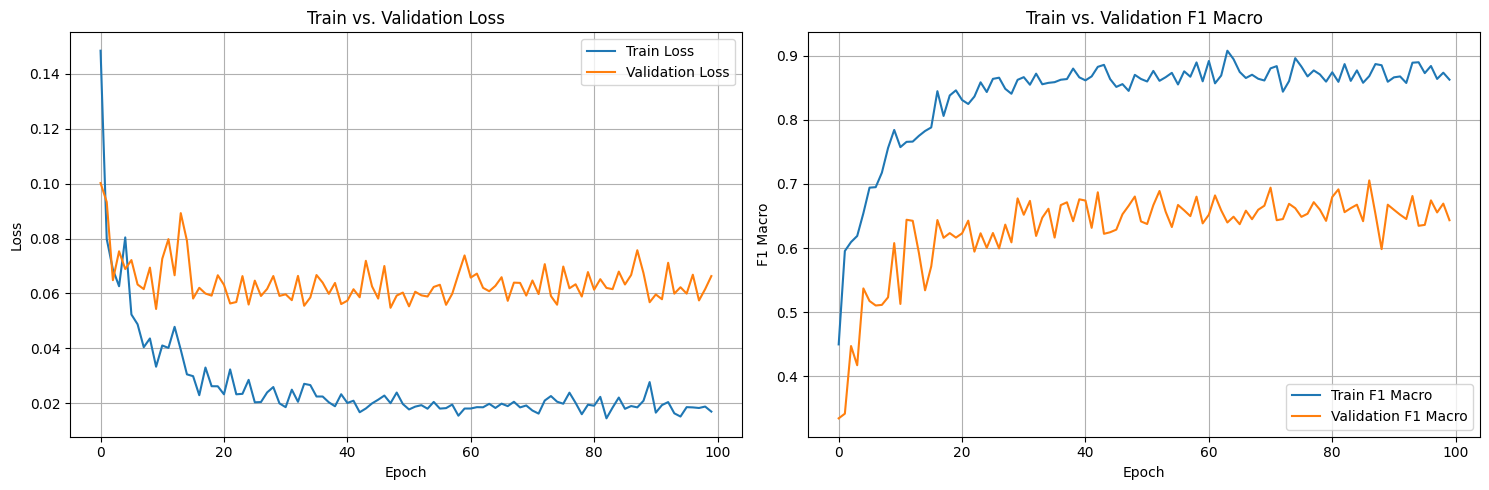

In [54]:
#INPUT: output_metrics_path
output_metrics_path="/kaggle/working/downstream_sslsubsetv3/logs/exp_20260227_232634/version_0/metrics.csv"
# Load the CSV file
metrics_df = pd.read_csv(output_metrics_path)
metrics_df_ = metrics_df.dropna(how='all') # Drop rows where all values are NaN
metrics_df_ = metrics_df_.ffill() # Forward-fill NaN values (carry last valid observation forward)
metrics_df_ = metrics_df_.groupby('epoch').last().reset_index()

# plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(metrics_df_["epoch"], metrics_df_["train_loss"], label="Train Loss")
axes[0].plot(metrics_df_["epoch"], metrics_df_["val_loss"], label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs. Validation Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(metrics_df_["epoch"], metrics_df_["train_f1_macro"], label="Train F1 Macro")
axes[1].plot(metrics_df_["epoch"], metrics_df_["val_f1_macro"], label="Validation F1 Macro")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 Macro")
axes[1].set_title("Train vs. Validation F1 Macro")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Inference

In [57]:
# INPUT: downstream_ckpt_path
downstream_ckpt_path= "/kaggle/working/downstream_sslsubsetv3/checkpoints_final_tuned/moco-epoch=086-val_f1_macro=0.7055.ckpt"

if do_inference:
    # prediction
    test_dataset = S2Dataset(root_dir=evaluation_data_dir, bands=bands, class_idx=class_idx, labeled=False, transform=transform)
    # sanity check
    print(test_dataset.__len__())
    img, img_id = test_dataset.__getitem__(0)
    print(f"Shape: {img.shape}")

    # INPUT: checkpoint_path
    
    # Load the downstream trained best checkpoint for inference
    # checkpoint_path = downstream_ckpt_path
    model = MoCoClassifier.load_from_checkpoint(downstream_ckpt_path)
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define class names using your class_idx
    class_names = {v: k for k, v in class_idx.items()}  # Reverse class_idx to map indices to names
    
    # Create the test DataLoader
    test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4,
                            worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

    # predictions
    image_ids = []
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            imgs, img_ids = batch  # img_ids are the folder names
            imgs = imgs.to("cuda" if torch.cuda.is_available() else "cpu")
            # Get model predictions
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            image_ids.extend(img_ids)
            predictions.extend(preds)
    
    # Map predictions to class names
    predicted_classes = [class_names[pred] for pred in predictions]
    
    # Save to CSV
    results_df = pd.DataFrame({
        "Id": image_ids,
        "Category": predicted_classes
    })
    
    results_df.to_csv(f"{output_dir}/submission.csv", index=False)
    results_df.head(5)

40
Shape: torch.Size([13, 224, 224])
Loading custom MoCo checkpoint: /kaggle/input/models/rabinatwayana/ssl-subset-v3/pytorch/default/1/ssl_backbone_20260227_074423.pth
Detected input channels: 13
Missing keys: 2
Unexpected keys: 0


In [58]:
# Zip the output directory for download
import shutil

shutil.make_archive("/kaggle/working/downstream_sslsubsetv3", 'zip', "/kaggle/working/downstream_sslsubsetv3")

'/kaggle/working/downstream_sslsubsetv3.zip'